In [17]:
#%%
import itertools
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#%%
F = 0               # force generated (mN)
Fm = 1              # peak theroretical force (mN)
T1 = 49             # time constant for elastic relaxation (ms) default-49
T2 = 720            # time constant for relaxation with active contractile apparatus (ms) default-720
Ta = 4e-13          # conc of activated tropomyosin (M)
To = 10.22e-6       # total tropomyosin (M)
A = 0.009e5         # constant related to time constant of force increase (ms-1)
k = 0               # has a non-zero value k' for 4ms post action potential
k0 = 1e-1           # Ca uptake rate into SR (ms-1)
k1 = 1.43e9         # forward rate of tropomyosin Ca binding (M-2ms-1)
k2 = 0.036          # backward rate of tropomyosin Ca binding (ms-1)
CAsp = 1e-9         # Cytoplasmic Ca (M)
CAsr = 0.001        # SR Ca (M)


def force_differential(F,Fm,T1,T2,Ta,To,A):
    return A*Ta*(1-(F/Fm))-F/(T1+T2*(Ta/To))

def ca_differential(CAsp,CAsr,k1,k2,k0,k,Ta,To):
    return 2*(k1*CAsp**2 + k2)*Ta - 2*k1*To*CAsp**2 + k*CAsr - (k+k0)*CAsp

def tropomyosin_differential(k1,To,Ta,CAsp):
    return k1*To*CAsp**2 - (k1*CAsp**2 + k2)*Ta

def pulse_train(pulse_positions, pulse_length, time_series, k_prime):
    k_value = np.zeros(shape=time_series.shape)
    
    for p in pulse_positions:
        k_value[p:p+pulse_length] = k_prime        
        
    return k_value

In [18]:
#%%
time_period = 2000

# convert time period to us and generate time axis for model
micro = 1e3
sample_rate = int(micro)
time_series = np.linspace(0,time_period,time_period*sample_rate+1)


# user defined variable search space
T1s = np.linspace(20,400,1)
k0s = np.linspace(1e-1,1e-2,1)
k_value = {
    '0Hz': pulse_train([0],
                       4*sample_rate,
                       time_series,
                       0),
    '1Hz': pulse_train([i*sample_rate for i in [200]], 
                      4*sample_rate, 
                      time_series, 
                      1),
    '5Hz' : pulse_train([i*sample_rate for i in np.linspace(200,1000,5, dtype='int')], 
                          4*sample_rate, 
                          time_series, 
                          1),
    '10Hz' : pulse_train([i*sample_rate for i in np.linspace(200,1000,9, dtype='int')], 
                          4*sample_rate, 
                          time_series, 
                          1)
    
}

# count permutations generated by the user for future reference
total_models = len([i for i in itertools.product(T1s, k0s, k_value)])

# initialise dicts to hold model outcomes
force = {}
troponin = {}
calcium = {}

# for all values in the user defined space
for _T1, _k0, _k_val in itertools.product(T1s, k0s, k_value):

    # each individial model populates growing list
    trop = []
    cal = []
    newtons = []

    # for every time step in the model, note we loop through the k_value list as well as time
    for t,k_prime in zip(time_series,k_value[_k_val]):
            
        # adjust CAsp for given time step
        CAsp = CAsp + ca_differential(CAsp,CAsr,k1,k2,_k0,k_prime,Ta,To)/sample_rate
        
        # calculate activated tropomyosin from asjusted CAsp
        Ta = Ta + tropomyosin_differential(k1,To,Ta,CAsp)/sample_rate
        
        # force output from these variable
        F = F + force_differential(F,Fm,_T1,T2,Ta,To,A)/sample_rate

        # add timestep value to growing list
        trop.append(Ta)
        cal.append(CAsp)
        newtons.append(F)

    # add complete timeseries to sim dict
    force[_T1,_k0,_k_val] = newtons
    #troponin[_T1,_k0,_k_val] = trop
    #calcium[_T1,_k0,_k_val] = cal

    # print progress
    print(f'Simulating; T1 = {_T1}, k0 = {_k0}, Pulse Train = {_k_val}')

Simulating; T1 = 20.0, k0 = 0.1, Pulse Train = 0Hz
Simulating; T1 = 20.0, k0 = 0.1, Pulse Train = 1Hz
Simulating; T1 = 20.0, k0 = 0.1, Pulse Train = 5Hz
Simulating; T1 = 20.0, k0 = 0.1, Pulse Train = 10Hz


In [105]:
import random
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



#%% duplicate and scale to produce different curves for training
duplcates = 100
target_rate = 100

# full rate is in Hz and model time step is us giving 1e6
full_rate = 1e6
slice_rate = int(full_rate/target_rate)
scales = np.tile(np.arange(1,11,1).reshape((10,1)), (duplcates, 1))

# subsample at target rate using random start point
force_subsample = {str(key):np.array(value[np.random.randint(1,slice_rate-1)::slice_rate])
                       for key, value in force.items()}

# duplicate to allow scaling
force_subsample = {key:np.tile(value, (duplcates*10,1))
                       for key, value in force_subsample.items()}

# scale force values to give multiple peak heights
force_subsample = {key:value*scales 
                   for key, value in force_subsample.items()}

# add random noise to scaled waveforms
noised_waveforms = {key:value+np.random.default_rng().normal(0, 0.1, value.shape)
                    for key, value in force_subsample.items()}

# add sporadic noise, eg stim noise
sporadic_len = 4
line_noise_len = 10
for key, value in noised_waveforms.items():
    start = np.random.randint(18,20, value.shape[0])
    n = np.random.default_rng().normal(-.5, .05, value.shape[0])
    
    noise_array = []
    
    for i,ar in enumerate(range(value.shape[0])):
        ar = np.zeros(value.shape[1])
        ar[[range(start[i], start[i]+sporadic_len)]] = n[i]
        noise_array.append(ar)
        
    noised_waveforms[key] = value+noise_array

#%% concat into one array
Y = np.concatenate([v for v in noised_waveforms.values()])
X = np.concatenate([v for v in force_subsample.values()])

# shuffle array order before flattening to prevent regular sequences in the waveform
order = np.arange(Y.shape[0]).tolist()
random.shuffle(order)

Y = Y.take(order, axis=0).flatten()
X = X.take(order, axis=0).flatten()

#%% add 60Hz line noise to the waveforms
sin_waves = []

# Generate 60Hz sine waves of varying lengths at 10,000 Hz then subsample to 100 Hz with random start point to acount for random phase position 
for i in range(0, Y.shape[0]//1000, 1):
    sin_len = np.random.randint(2, 7, 1)[0] * 1000 # length in samples
    t = np.arange(sin_len) / 10000  # time array
    sin_wave = np.sin(2 * np.pi * 60 * t) # sine wave at 60Hz
    sin_wave = np.random.default_rng().normal(3, 0.1, 1) * sin_wave[np.random.randint(0,100,1)[0]::100] # random amplitude and subsample to 100Hz

    sin_waves.append(sin_wave)

# Choose random start indices every 10s, ensuring space for 10 samples
line_noise_array = np.zeros(shape=Y.shape)

positions = np.arange(0,Y.shape[0])[::1000]  + np.random.randint(0,999,1)

# Place the sin_wave at each random location
for pos, sin_wave in zip(positions, sin_waves):
    line_noise_array[pos:pos+len(sin_wave)] = sin_wave     

# Add the line noise to the waveforms
Y += line_noise_array

# Nomalise data around 0


# reshape for model training
training_waveforms = np.array([X,Y])
training_waveforms = training_waveforms.reshape(2,-1,200)
training_waveforms = np.moveaxis(training_waveforms, 0, 1)

nomralisation_factor = np.array([training_waveforms[:,1].max(axis=1),training_waveforms[:,1].min(axis=1)])
training_waveforms = (training_waveforms.T - nomralisation_factor[1]) / (nomralisation_factor[0] - nomralisation_factor[1])
training_waveforms = training_waveforms.T

# split into test and validation sets
training_split = .7
val_split = .2
test_split = .1

training_set = training_waveforms[:int(training_waveforms.shape[0]*training_split)]
validation_set = training_waveforms[int(training_waveforms.shape[0]*training_split):int(training_waveforms.shape[0]*(training_split+val_split))]
test_set = training_waveforms[int(training_waveforms.shape[0]*(training_split+val_split)):]

# save as torch data
torch.save(torch.tensor(training_set).float(), r'.\\outputs\\training_set.pt')
torch.save(torch.tensor(validation_set).float(), r'.\\outputs\\validation_set.pt')
torch.save(torch.tensor(test_set).float(), r'.\\outputs\\test_set.pt')


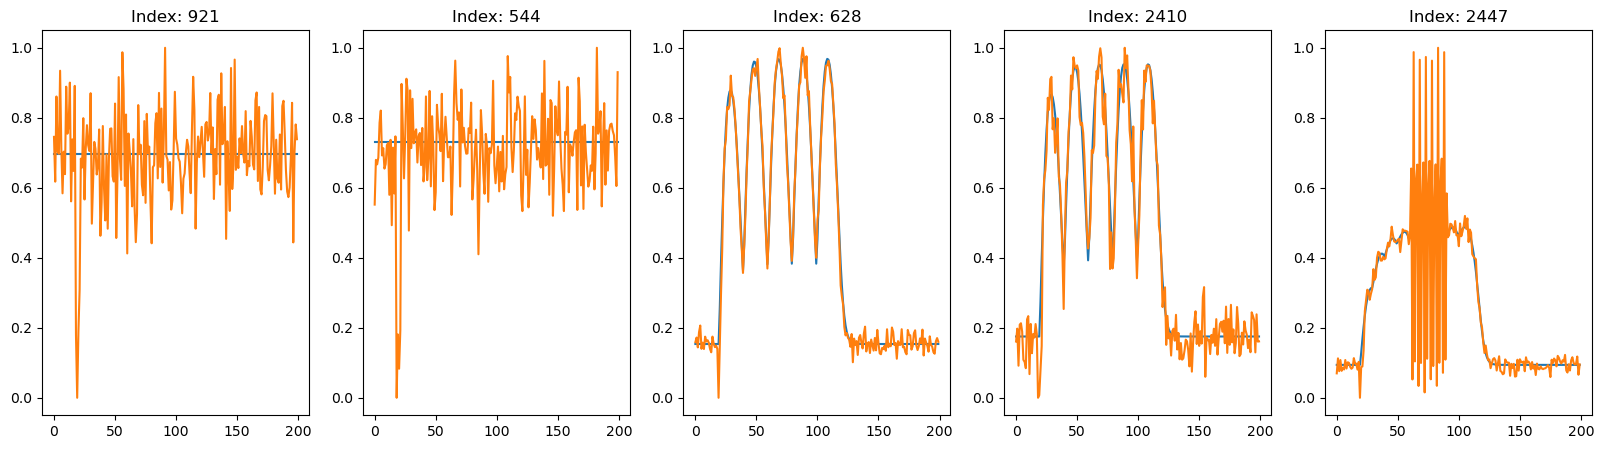

In [107]:
fig, axs = plt.subplots(1,5, figsize=(20,5))

for i in range(5):
    viewing_index = np.random.randint(0,training_set.shape[0]) 
    axs[i].plot(training_set[viewing_index,0,:])
    axs[i].plot(training_set[viewing_index,1,:])
    axs[i].set_title(f'Index: {viewing_index}')
plt.show()

In [86]:
torch.load(r'.\\outputs\\training_waveforms.pt')[:,0,:].shape


torch.Size([4000, 200])

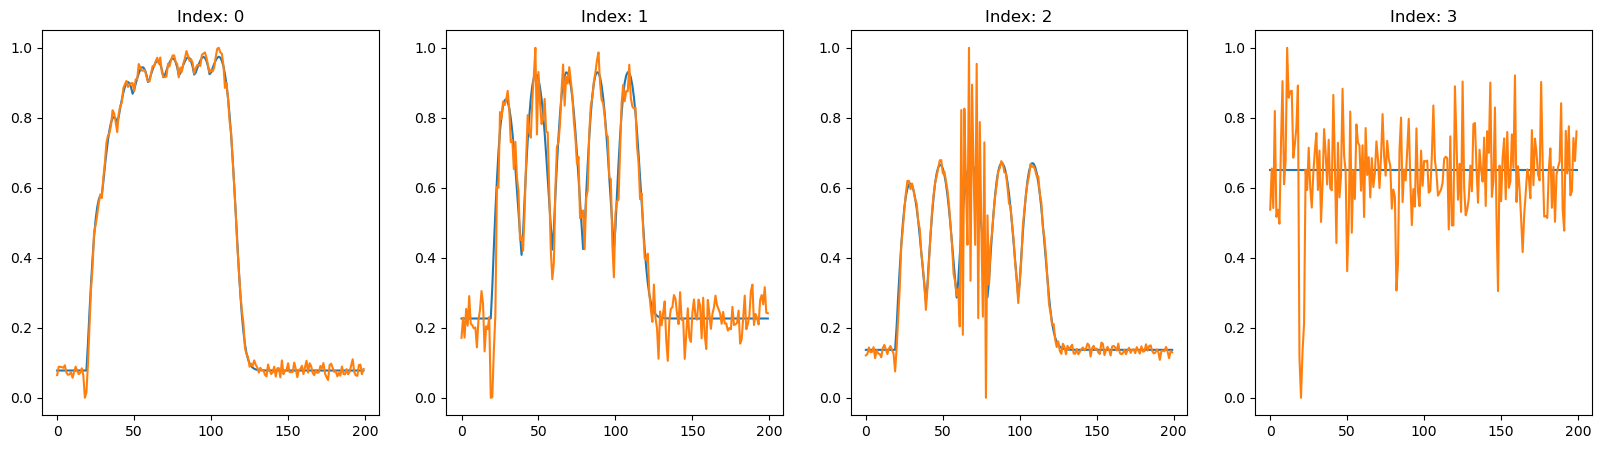

In [138]:
import torch

from torch.utils.data import Dataset, DataLoader

class WaveformDataset(Dataset):
    def __init__(self, training_set_file):
        pt_data = torch.load(training_set_file)
        self.pure_waveform_train = pt_data[:,0,:] 
        self.noisy_waveform_train = pt_data[:,1,:]

    def __len__(self):
        return self.pure_waveform_train.shape[0]

    def __getitem__(self, idx):
        Pure_waveform = self.pure_waveform_train[idx]
        Noisey_waveform = self.noisy_waveform_train[idx]
        return Pure_waveform, Noisey_waveform



training_data = WaveformDataset(r'.\\outputs\\training_set.pt')
validation_data = WaveformDataset(r'.\\outputs\\validation_set.pt')

train_iter = DataLoader(training_data, batch_size=4, shuffle=False)

fig, axs = plt.subplots(1,4, figsize=(20,5))

for i in range(4):
    X = next(iter(train_iter))[0][i]
    Y = next(iter(train_iter))[1][i]
    axs[i].plot(X)
    axs[i].plot(Y)
    axs[i].set_title(f'Index: {i}')

plt.show()

TypeError: '_SingleProcessDataLoaderIter' object is not subscriptable